<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep10-eda-submission-modeling?scriptVersionId=202362867" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

- Version 1 (09/30/2024)
    * EDA 
    * Baseline modeling 1.0
    
    
- Version 2 (10/01/2024)
    * Baseline modeling 1.0 updated
    

- Version 3 (10/03/2024)
    * Baseline modeling 2.0 added
    
    
- Version 4 (10/03/2024)
    * Hiding Optuna output in baseline modeling 2.0
 

- Version 5 (10/08/2024)
    * Adding `GradientBoostingClassisifer` in baseline modeling 2.0
    * Baseline modeling 3.0
 

- Version 6 (10/11/2024)
    * Adding another `CatBoostClassifier` model in baseline modeling 2.0
 

- Version 7 (10/11/2024)
    * Fixing bug in the last `CatBoostClassifier` model of baseline modeling 2.0
 

- Version 8 (10/20/2024)
    * Baseline modeling 4.0 added.
 

- Version 9 (10/20/2024)
    * Fixing typo.
    
    
# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import gc

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import kurtosis, skew, gmean, mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR

from category_encoders import TargetEncoder

import xgboost as xgb

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e10/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (58645, 12)
The dimension of the test dataset is: (39098, 11)
CPU times: user 156 ms, sys: 45.6 ms, total: 201 ms
Wall time: 264 ms


In [3]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
print('--- Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Test ---\n')
print(100*test.isnull().sum() / train.shape[0])

--- Train ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64


--- Test ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64


There are no missing values neither in the `train` nor `test` data frames. Next, we check for potential duplicates.

In [6]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the loan_status column, there are {sum(train.drop(columns=['loan_status']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the loan_status column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [7]:
temp_train = train.drop(columns=['loan_status'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the distribution of `loan_status`.

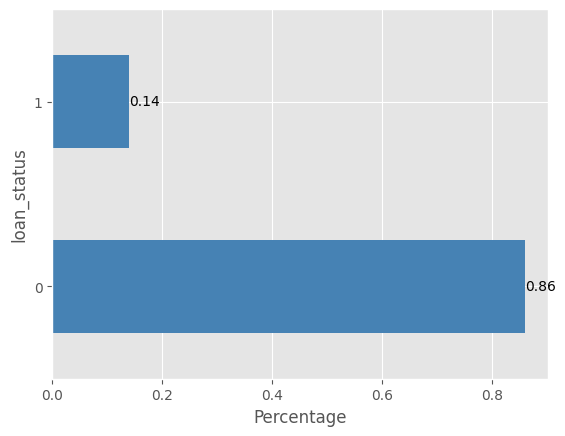

In [8]:
ax = round(train['loan_status'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

From the above chart, we see that this is an imbalanced dataset. `loan_status=1` is the less frequent label. Next, we explore the relationships between the input features and `loan_status`.

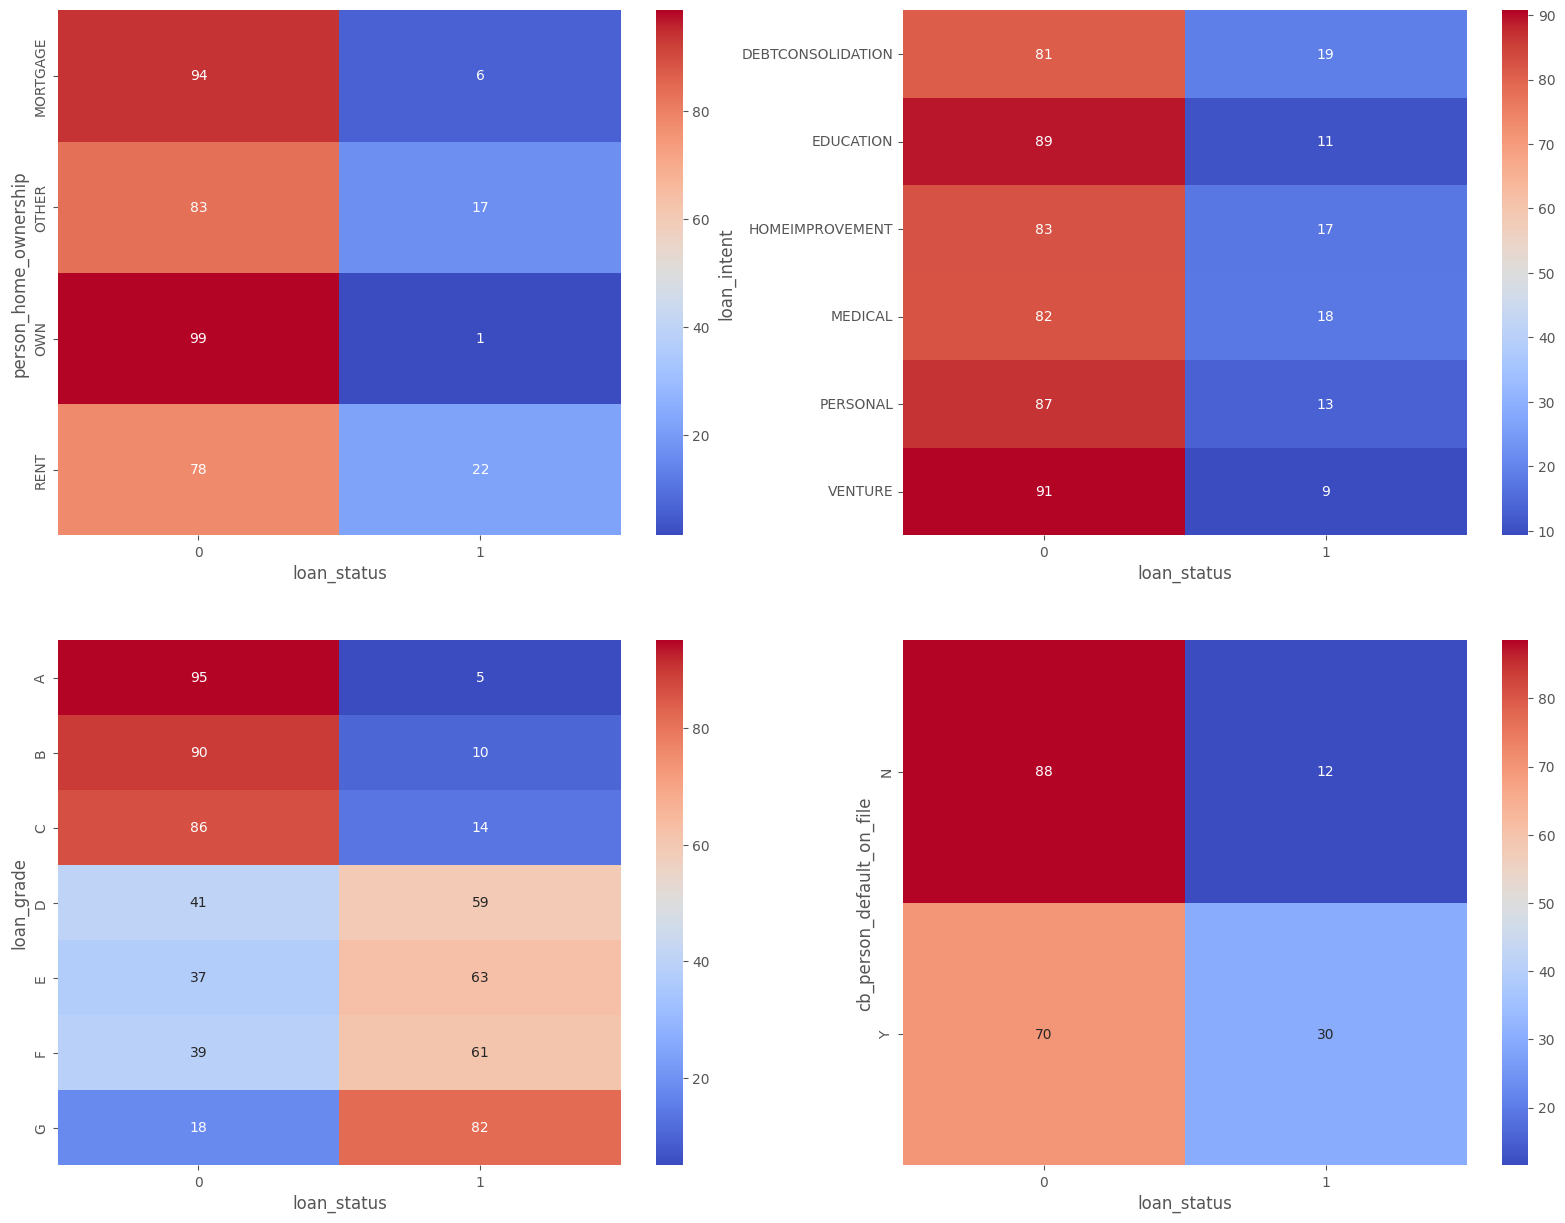

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['person_home_ownership'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 0])
sns.heatmap(data=round(100*pd.crosstab(train['loan_intent'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 1])
sns.heatmap(data=round(100*pd.crosstab(train['loan_grade'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 0]);
sns.heatmap(data=round(100*pd.crosstab(train['cb_person_default_on_file'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 1]);

These are a couple of observations from the above charts:

- When `loan_grade` is equal to `D, E, F,` and `G` have the higher proportions of `loan_status=1`
- `cb_person_default_on_file=Y` have a higher proportion `loan_status=1` when compared to `cb_person_default_on_file=N`

Next, let's explore the distribution of the numerical features and potential relationships with `loan_status`.

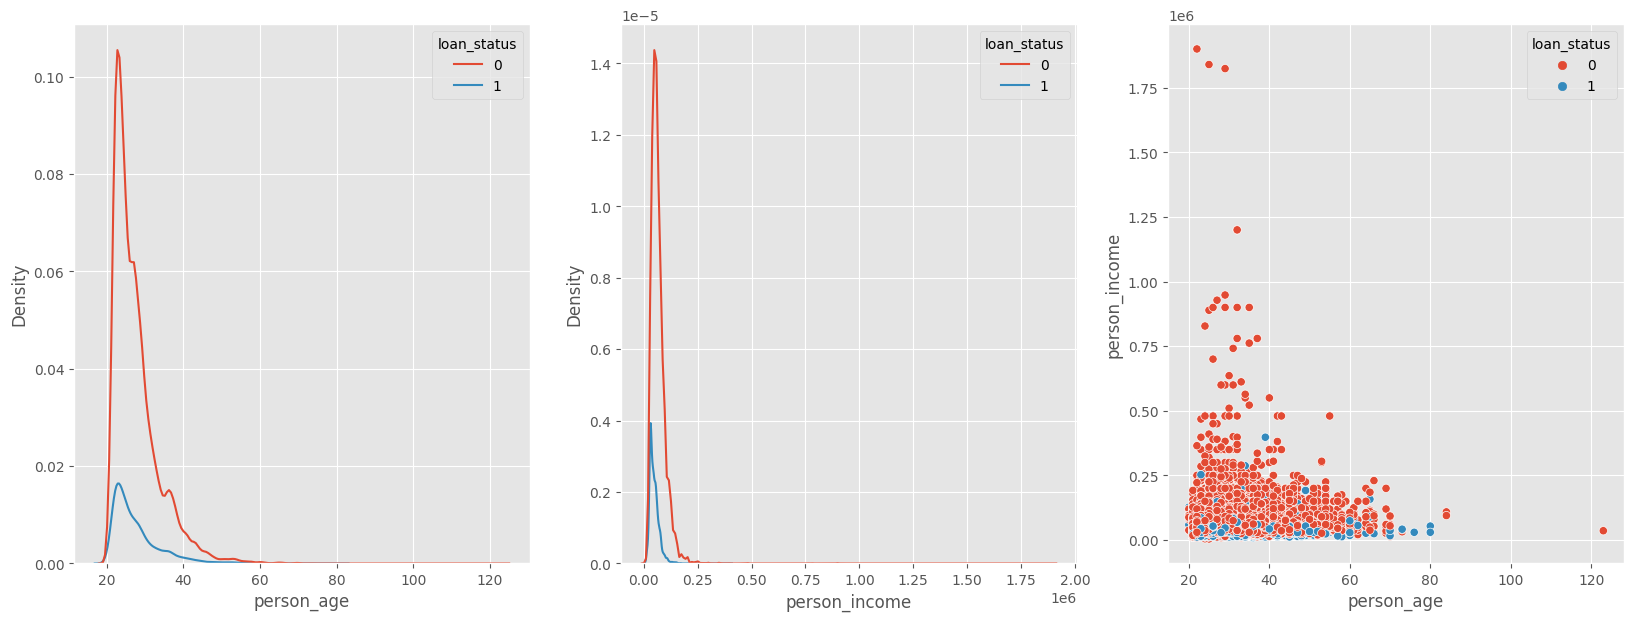

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_age', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='person_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_age', y='person_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_age` and `person_income`.
- There is one person with `person_age=123`.

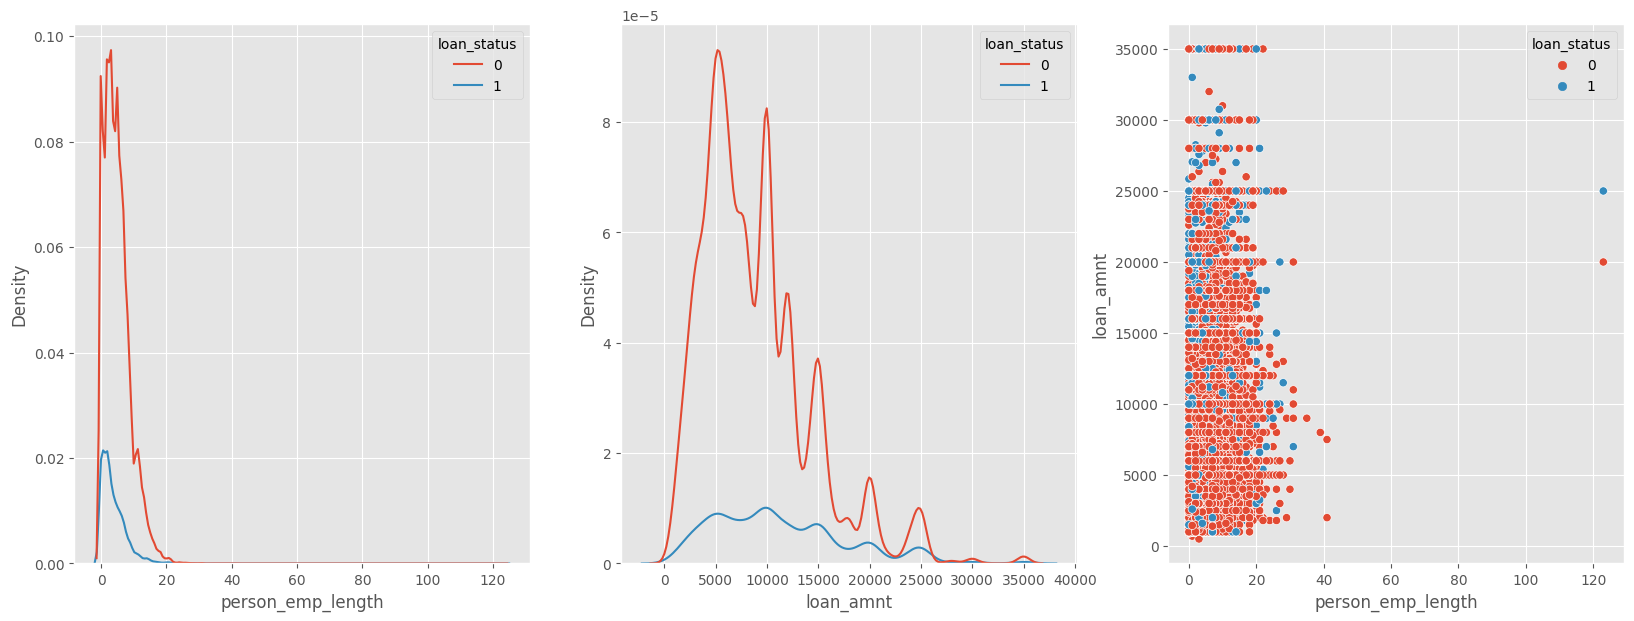

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_emp_length', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_amnt', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_emp_length', y='loan_amnt', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_emp_length` and `loan_amnt`.
- There are two persons with `person_emp_length=123`.

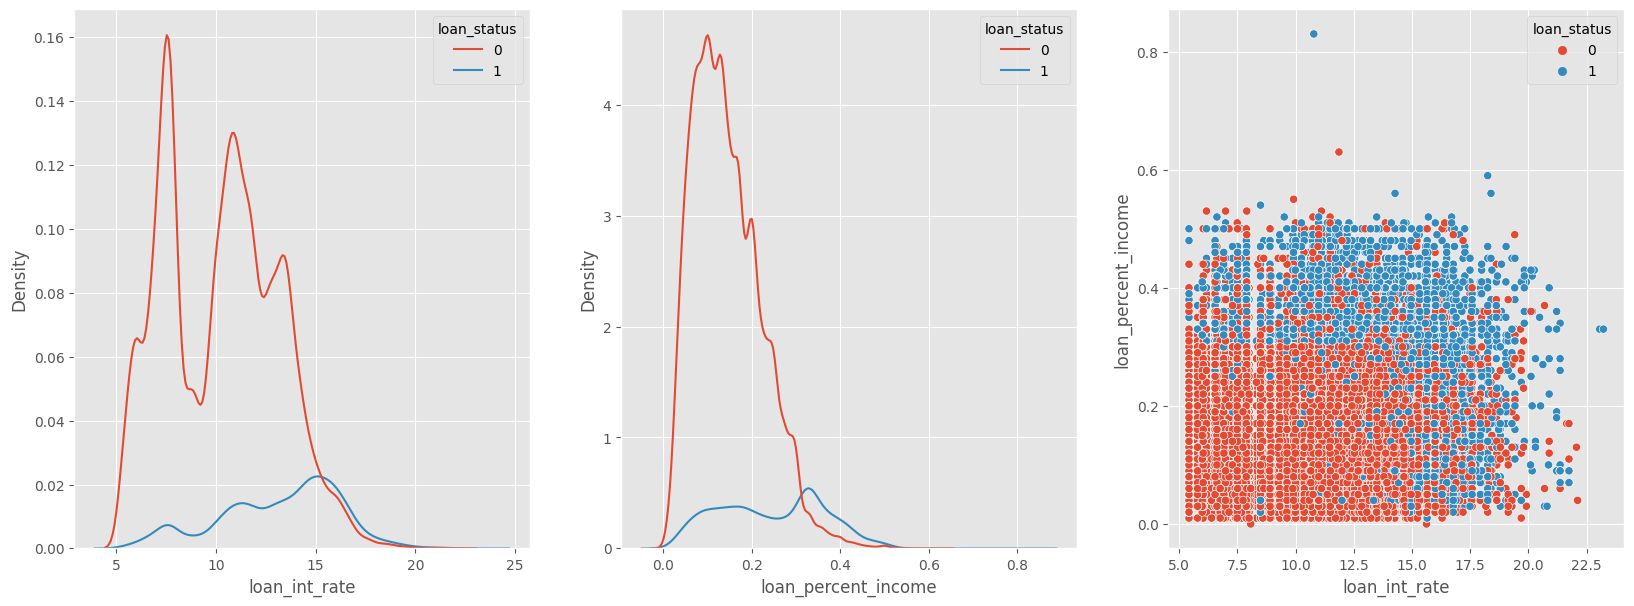

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='loan_int_rate', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_percent_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='loan_int_rate', y='loan_percent_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `loan_int_rate` and `loan_percent_income`.
- There are two loans with `loan_int_rate>23`.
- There are two loans with `loan_percent_income>0.6`.

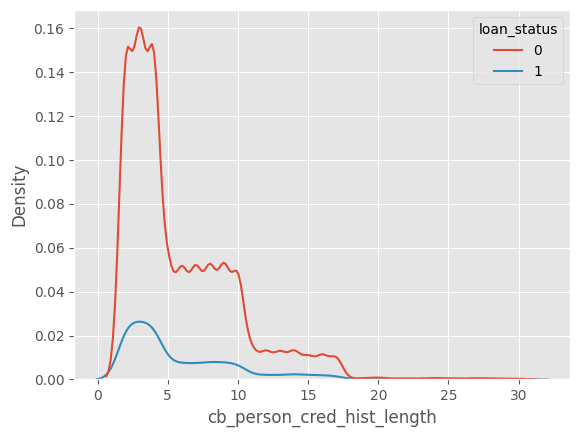

In [13]:
sns.kdeplot(data=train, x='cb_person_cred_hist_length', hue='loan_status');

From the above chart, we see that the distribution of `cb_person_cred_hist_length` is similar whether `loan_statu` is 0 or 1.

# Baseline Modeling 1.0

We first preprocess the data as follows.

In [14]:
%%time
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

def converting_datatypes(df, cat_cols, df_train=False):
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    df['person_age'] = df['person_age'].astype('int32')
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32') 
    
    if df_train==True:

        df['loan_status'] = df['loan_status'].astype('int8')
        
    return df
        
train = converting_datatypes(train, cat_cols ,df_train=True)
test = converting_datatypes(test, cat_cols)


def clip_data(df):
    
    df['person_age'] = df['person_age'].clip(None, 90)
    df['person_emp_length'] = df['person_emp_length'].clip(None, 60) 
    
    return df

train = clip_data(train)
test = clip_data(test)

CPU times: user 49.2 ms, sys: 2.01 ms, total: 51.2 ms
Wall time: 50.6 ms


Then, we define the input and target feature for modeling purposes.

In [15]:
%%time
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

CPU times: user 4.3 ms, sys: 131 µs, total: 4.43 ms
Wall time: 4.8 ms


First, we train the `RandomForestClassifier` model as follows.

In [16]:
# Converting label to dummies
train_dummies = pd.get_dummies(X[cat_cols], drop_first=True, dtype='int8')
RF_train = pd.concat([X.drop(columns=cat_cols, axis=1), train_dummies], axis=1)

test_dummies = pd.get_dummies(test[cat_cols], drop_first=True, dtype='int8')
RF_test = pd.concat([test.drop(columns=cat_cols, axis=1), test_dummies], axis=1)

rf_params = {'n_estimators': 148,
             'max_depth': 15,
             'min_samples_split': 17,
             'min_samples_leaf': 6,
             'n_jobs': -1}

scores, rf_oof_preds, rf_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(RF_train, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = RF_train.iloc[train_index], RF_train.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    rf_md = RandomForestClassifier(**rf_params).fit(X_train, y_train)
    preds = rf_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['rf_preds'] = preds
    oof_preds['fold'] = i
    rf_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['rf_preds'] = rf_md.predict_proba(RF_test)[:, 1]
    test_preds['fold'] = i
    rf_test_preds.append(test_preds)

rf_oof_score = np.mean(scores)
rf_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the RandomForest model is {rf_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the RandomForest model is {rf_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9370100355948144
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9453092225092559
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9390728681801407
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.938730491303675
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.936289806073737
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9392805560086825
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9385623265300777
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.935900638571733
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9324168922048526
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.933405172157177
The 10-fold average oof ROC-AUC score of the RandomForest model is 0.9375978009134144
The 10-fold std oof ROC-AUC score of t

Next, we train the `LightGBM` model as follows.

In [17]:
%%time
lgb_params = {'learning_rate': 0.09030331403653566,
              'n_estimators': 190,
              'max_depth': 15,
              'reg_alpha': 0.25370376964322267,
              'reg_lambda': 0.06912978243728862,
              'num_leaves': 38,
              'colsample_bytree': 0.4816656035216278,
              'verbose': -1,
              'n_jobs': -1}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9615514101022608
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9621418792633423
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9604949941072128
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9578878822871156
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9598626206830871
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9618800180509929
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9586113118761483
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9603635441386068
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9543917136893444
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9596434095420214
The 10-fold average oof ROC-AUC score of the LGBM model is 0.9596828783740132
The 10-fold std oof ROC-AUC score of the L

After that, we train the `XGBoost` model as follows.

In [18]:
%%time
xgb_params = {'n_estimators': 199,
              'max_depth': 12,
              'learning_rate': 0.09304789779291263,
              'gamma': 0.2571967403496238,
              'min_child_weight': 20,
              'colsample_bytree': 0.5141737333809174,
              'n_jobs': -1,
              'enable_categorical': True}

scores, xgb_oof_preds, xgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
                        
    xgb_md = XGBClassifier(**xgb_params).fit(X_train, y_train)
    preds = xgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['xgb_preds'] = preds
    oof_preds['fold'] = i
    xgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['xgb_preds'] = xgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    xgb_test_preds.append(test_preds)

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the XGBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9584907322531875
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9599021440220951
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9557338603111868
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9544329234175783
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9564890894156022
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9584948615395973
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9561903832025748
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9570726909672401
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9558919940988971
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9572874930195285
The 10-fold average oof ROC-AUC score of the XGBoost model is 0.9569986172247488
The 10-fold std oof ROC-AUC score of th

Next, we train the `CatBoost` model as follows.

In [19]:
cb_params = {'loss_function': 'Logloss',
             'iterations': 195,
             'learning_rate': 0.09381481508561976,
             'depth': 11,
             'bagging_temperature': 0.0850640366226123,
             'l2_leaf_reg': 0,
             'grow_policy': 'Lossguide',
             'task_type': 'CPU'}

test_pool = Pool(data=test, cat_features=cat_cols)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostClassifier(**cb_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict_proba(eval_pool)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict_proba(test_pool)[:, 1]
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof RMSE score is 0.9571600338091213
------------ Working on Fold 1 ------------
The oof RMSE score is 0.9583169247985143
------------ Working on Fold 2 ------------
The oof RMSE score is 0.9621294984583517
------------ Working on Fold 3 ------------
The oof RMSE score is 0.9557538600730943
------------ Working on Fold 4 ------------
The oof RMSE score is 0.9523503291627481
------------ Working on Fold 5 ------------
The oof RMSE score is 0.9593474018358192
------------ Working on Fold 6 ------------
The oof RMSE score is 0.9563201693649885
------------ Working on Fold 7 ------------
The oof RMSE score is 0.9564428113349757
------------ Working on Fold 8 ------------
The oof RMSE score is 0.9550111151727168
------------ Working on Fold 9 ------------
The oof RMSE score is 0.9550008751635721
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9567833019173901
The 10-fold std oof ROC-AUC score of the CatBoost model is 0.0015265

Finally, we run an Optuna experiment to blend the out-of-fold predictions of `RandomForest`, `LightGBM`, `XGBoost`, and `CatBoost`.

In [20]:
%%time
oof_preds = pd.concat(lgb_oof_preds)
oof_preds['xgb_preds'] = pd.concat(xgb_oof_preds)['xgb_preds']
oof_preds['cat_preds'] = pd.concat(cat_oof_preds)['cat_preds']
oof_preds['rf_preds'] = pd.concat(rf_oof_preds)['rf_preds']


def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-5, 1) for n in range(4)]

    scores = list()
    for i in range(0, 10):
        
        x_test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
        ens_pred = (weights[0]*x_test['lgb_preds'].values +
                    weights[1]*x_test['xgb_preds'].values + 
                    weights[2]*x_test['cat_preds'].values + 
                    weights[3]*x_test['rf_preds'].values) 
        
        y_test = x_test['y']
        score = roc_auc_score(y_test, ens_pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3000, n_jobs=-1)

[I 2024-10-20 20:40:24,872] A new study created in memory with name: no-name-0ea857a3-87ce-4cf3-a158-3cd8b3613f45
[I 2024-10-20 20:40:25,070] Trial 0 finished with value: 0.9584003824069847 and parameters: {'weight0': 0.33726678042496333, 'weight1': 0.7851157835530472, 'weight2': 0.574481848409078, 'weight3': 0.33869377363629766}. Best is trial 0 with value: 0.9584003824069847.
[I 2024-10-20 20:40:25,078] Trial 1 finished with value: 0.9590914887199556 and parameters: {'weight0': 0.6471474499716992, 'weight1': 0.7817838867320561, 'weight2': 0.5353735592569862, 'weight3': 0.2926952788855772}. Best is trial 1 with value: 0.9590914887199556.
[I 2024-10-20 20:40:25,100] Trial 2 finished with value: 0.9579460844841374 and parameters: {'weight0': 0.8831502718496675, 'weight1': 0.29499708536375213, 'weight2': 0.4735234806851355, 'weight3': 0.5608062268316873}. Best is trial 1 with value: 0.9590914887199556.
[I 2024-10-20 20:40:25,155] Trial 3 finished with value: 0.9565216040935265 and parame

CPU times: user 7min 20s, sys: 2.53 s, total: 7min 23s
Wall time: 7min 21s


In [21]:
%%time
print("Best Trial:")
best_trial = study.best_trial

print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.9604004779232749
  Params: 
    weight0: 0.9999673539365794
    weight1: 0.3305549202230723
    weight2: 0.4520350308077855
    weight3: 7.820786752574755e-05
CPU times: user 497 µs, sys: 0 ns, total: 497 µs
Wall time: 482 µs


In [22]:
%%time
w = study.best_trial.params
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    optuna_pred = (w['weight0']*test['lgb_preds'] + w['weight1']*test['xgb_preds'] + w['weight2']*test['cat_preds'] + w['weight3']*test['rf_preds'])
    score = roc_auc_score(y_test, optuna_pred)
    scores.append(score)

print(f"The 10-fold oof average ROC-AUC score of the Optuna Blender is {np.mean(scores)}")


The 10-fold oof average ROC-AUC score of the Optuna Blender is 0.9604004779232749
CPU times: user 117 ms, sys: 1.96 ms, total: 119 ms
Wall time: 118 ms


The following table summarizes the results so far.

In [23]:
results = pd.DataFrame()
results['Model'] = ['RF', 'LGBM', 'XGB', 'CatBoost', 'Optuna Blend']
results['10-fold oof ROC-AUC'] = [rf_oof_score, lgb_oof_score, xgb_oof_score, cat_oof_score, np.mean(scores)] 
print(results)

          Model  10-fold oof ROC-AUC
0            RF             0.937598
1          LGBM             0.959683
2           XGB             0.956999
3      CatBoost             0.956783
4  Optuna Blend             0.960400


From the above, we see that the `Optuna Blend` has the better out-of-fold `ROC-AUC` score. Thus, we use the `Optuna Blend` strategy to blend the predictions on the `test` data set.

In [24]:
%%time
test_preds = pd.concat(lgb_test_preds)
test_preds['xgb_preds'] = pd.concat(xgb_test_preds)['xgb_preds']
test_preds['cat_preds'] = pd.concat(cat_test_preds)['cat_preds']
test_preds['rf_preds'] = pd.concat(rf_test_preds)['rf_preds']
test_preds.head()

CPU times: user 20.3 ms, sys: 13 ms, total: 33.2 ms
Wall time: 32.7 ms


,lgb_preds,fold,xgb_preds,cat_preds,rf_preds
0,0.987975,0,0.987820,0.990004,0.826854
1,0.012344,0,0.016124,0.016007,0.025353
2,0.534855,0,0.765667,0.626705,0.669953
3,0.010490,0,0.012575,0.013469,0.030599
4,0.053700,0,0.052235,0.048456,0.283214


In [25]:
%%time
test_pred_final = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']

    temp = test_preds[test_preds['fold']==i].reset_index(drop=True)
    optuna_pred = (w['weight0']*temp['lgb_preds'] + w['weight1']*temp['xgb_preds'] + w['weight2']*temp['cat_preds'] + w['weight3']*temp['rf_preds'])
    
    test_pred_final.append(optuna_pred)

CPU times: user 94.9 ms, sys: 0 ns, total: 94.9 ms
Wall time: 94.7 ms


In [26]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 12.5 ms, sys: 6.99 ms, total: 19.5 ms
Wall time: 32.9 ms


,id,loan_status
0,58645,1.762372
1,58646,0.028561
2,58647,1.099646
3,58648,0.020001
4,58649,0.095737


In [27]:
%%time
submission.to_csv('baseline_sub_1.csv', index=False)

del train, test, submission, X, Y, test_pred_final, scores, w, oof_preds, test_preds
gc.collect()

CPU times: user 316 ms, sys: 3.92 ms, total: 320 ms
Wall time: 321 ms


23120

# Baseline Modeling 2.0

In this section, we re-train the models by combining the competition and the original datasets for training purposes.

In [28]:
%%time
train = pd.read_csv('../input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e10/test.csv', index_col=0)
original = pd.read_csv('../input/loan-approval-prediction/credit_risk_dataset.csv')

cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

def converting_datatypes(df, cat_cols, df_train=False):
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    df['person_age'] = df['person_age'].astype('int32')
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32') 
    
    if df_train==True:

        df['loan_status'] = df['loan_status'].astype('int8')
        
    return df
        
train = converting_datatypes(train, cat_cols ,df_train=True)
test = converting_datatypes(test, cat_cols)
original = converting_datatypes(original, cat_cols)

def clip_data(df):
    
    df['person_age'] = df['person_age'].clip(None, 90)
    df['person_emp_length'] = df['person_emp_length'].clip(None, 60) 
    
    return df

train = clip_data(train)
test = clip_data(test)
original = clip_data(original)

CPU times: user 283 ms, sys: 21 ms, total: 304 ms
Wall time: 323 ms


In [29]:
%%time
X = train.drop('loan_status', axis=1)
X['generated'] = 1
Y = train['loan_status']

X_org = original.drop('loan_status', axis=1)
X_org['generated'] = 0
y_org = original['loan_status']

test['generated'] = 1

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

CPU times: user 6.24 ms, sys: 8 µs, total: 6.25 ms
Wall time: 5.68 ms


First, we train the `GradientBoostingClassifier` model as follows.

In [30]:
%%time
dummies = pd.get_dummies(X[cat_cols], drop_first=True, dtype='int8')
X_gb = pd.concat([X.drop(columns=cat_cols, axis=1), dummies], axis=1)

dummies = pd.get_dummies(test[cat_cols], drop_first=True, dtype='int8')
test_gb = pd.concat([test.drop(columns=cat_cols, axis=1), dummies], axis=1)

dummies = pd.get_dummies(X_org[cat_cols], drop_first=True, dtype='int8')
X_org_gb = pd.concat([X_org.drop(columns=cat_cols, axis=1), dummies], axis=1)

gb_params = {'n_estimators': 473,
 'max_depth': 5,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'subsample': 0.8867385546845281,
 'random_state': 1}

scores, gb_oof_preds, gb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X_gb, Y)):

    print(f"------------ Working on Fold {i} ------------")
            
    X_train, X_test = X_gb.iloc[train_index], X_gb.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    X_train = pd.concat([X_train, X_org_gb], axis=0).reset_index(drop=True)
    y_train = pd.concat([y_train, y_org], axis=0).reset_index(drop=True)
    dat = pd.concat([X_train, y_train], axis=1).dropna().reset_index(drop=True)
    X_train = dat.drop(columns='loan_status', axis=1)
    y_train = dat['loan_status']

    GB_md = GradientBoostingClassifier(**gb_params).fit(X_train, y_train)
    GB_pred = GB_md.predict_proba(X_test)[:, 1]

    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['gb_preds'] = GB_pred
    oof_preds['fold'] = i
    gb_oof_preds.append(oof_preds)

    score = roc_auc_score(y_test, GB_pred)
    scores.append(score)
    print(f"The oof ROC-AUC score is {score}")

    test_preds = pd.DataFrame()
    test_preds['gb_preds'] = GB_md.predict_proba(test_gb)[:, 1]
    test_preds['fold'] = i
    gb_test_preds.append(test_preds)

gb_oof_score = np.mean(scores)
gb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the GradientBoosting model is {gb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the GradientBoosting model is {gb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9661363555195772
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9642504255901715
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.965268270615826
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9597926215164106
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9633561505220177
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9656792995833745
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9621960294959891
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9648219964922015
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9593986018815421
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.962862106369881
The 10-fold average oof ROC-AUC score of the GradientBoosting model is 0.9633761857586991
The 10-fold std oof ROC-AUC scor

Next, we train the `LGBMClassifier` model.

In [31]:
%%time
lgb_params = {'learning_rate': 0.09967204378010042,
              'n_estimators': 293,
              'max_depth': 11,
              'reg_alpha': 1.8071679385784074,
              'reg_lambda': 0.013057189102691127,
              'num_leaves': 35,
              'colsample_bytree': 0.4708077087365519,
              'verbose': -1,
              'n_jobs': -1}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
    
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9638856680277615
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9641099510720111
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9656387423959238
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9593485791835812
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9647554195783384
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9644300184677373
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9609979484260748
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9655080771048875
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9599027437271015
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9633239784102506
The 10-fold average oof ROC-AUC score of the LGBM model is 0.9631901126393668
The 10-fold std oof ROC-AUC score of the L

Next, we train the `LGBMClassifier` with `dart` booster.

In [32]:
%%time
lgb_dart_params = {'boosting_type': 'dart',
                   'learning_rate': 0.09755475070802529,
                   'n_estimators': 289,
                   'max_depth': 12,
                   'reg_alpha': 0.396286496452296,
                   'reg_lambda': 0.01930416713070059,
                   'num_leaves': 40,
                   'colsample_bytree': 0.5305154955728938,
                   'verbose': -1,
                   'n_jobs': -1}

scores, lgb_dart_oof_preds, lgb_dart_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
    
    lgb_md = LGBMClassifier(**lgb_dart_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_dart_preds'] = preds
    oof_preds['fold'] = i
    lgb_dart_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_dart_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_dart_test_preds.append(test_preds)

lgb_dart_oof_score = np.mean(scores)
lgb_dart_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM (dart) model is {lgb_dart_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM (dart) model is {lgb_dart_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9614359352864846
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9616566469446791
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9627113962929011
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9569488458470733
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9590528684182331
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.961950031136772
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9602625728856465
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9601849393279458
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9554581034788645
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9599215567671577
The 10-fold average oof ROC-AUC score of the LGBM (dart) model is 0.9599582896385759
The 10-fold std oof ROC-AUC score of

Next, we train the `LGBMClassifier` with `goss` booster.

In [33]:
%%time
lgb_goss_params = {'boosting_type': 'goss',
                   'learning_rate': 0.09833586641055655,
                   'n_estimators': 293,
                   'max_depth': 12,
                   'reg_alpha': 0.10125985871865179,
                   'reg_lambda': 0.1312779378943349,
                   'num_leaves': 40,
                   'colsample_bytree': 0.5037005285619212,
                   'verbose': -1,
                   'n_jobs': -1}

scores, lgb_goss_oof_preds, lgb_goss_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
    
    lgb_md = LGBMClassifier(**lgb_goss_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_goss_preds'] = preds
    oof_preds['fold'] = i
    lgb_goss_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_goss_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_goss_test_preds.append(test_preds)

lgb_goss_oof_score = np.mean(scores)
lgb_goss_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM (goss) model is {lgb_goss_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM (goss) model is {lgb_goss_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9630432971036058
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9622494970297973
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9658211211771288
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9588795371483673
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9633635313865312
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9638882505420656
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9601234992730784
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.964508128304933
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9585198662130899
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.961834057079716
The 10-fold average oof ROC-AUC score of the LGBM (goss) model is 0.9622230785258313
The 10-fold std oof ROC-AUC score of 

Next, we train the `XGBClassifier` model.

In [34]:
%%time
xgb_params = {'n_estimators': 299,
              'max_depth': 13,
              'learning_rate': 0.09641490775039248,
              'gamma': 0.33798576564250904,
              'min_child_weight': 21,
              'colsample_bytree': 0.3506441304881963,
              'n_jobs': -1,
              'enable_categorical': True}

scores, xgb_oof_preds, xgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
                        
    xgb_md = XGBClassifier(**xgb_params).fit(X_train, y_train)
    preds = xgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['xgb_preds'] = preds
    oof_preds['fold'] = i
    xgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['xgb_preds'] = xgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    xgb_test_preds.append(test_preds)

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the XGBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9626680634754348
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9629175843144725
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9608897513124843
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9580771657480267
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9614190307258248
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9635172288153857
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9573348828292907
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9616571192472878
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.959326445538035
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9599598972665129
The 10-fold average oof ROC-AUC score of the XGBoost model is 0.9607767169272755
The 10-fold std oof ROC-AUC score of the

Next, we train the `CatBoost` model.

In [35]:
%%time
cat_params = {'loss_function': 'Logloss',
              'iterations': 490,
              'learning_rate': 0.09054784949573864,
              'depth': 12,
              'bagging_temperature': 0.010287865831919592,
              'l2_leaf_reg': 4,
              'grow_policy': 'Lossguide',
              'task_type': 'CPU'}

cat_cols_cat = ['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

X = X.astype('str')
X_org = X_org.astype('str') 
test_pool = Pool(data=test.astype('str'), cat_features=cat_cols_cat)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols_cat)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols_cat)
            
    cat_md = CatBoostClassifier(**cat_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict_proba(eval_pool)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict_proba(test_pool)[:, 1]
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {cat_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9652356519565243
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9703994000071429
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9691571528910368
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.961930691301294
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9660823085439458
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9679654411598357
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9616137778132342
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9738274891854788
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.96564476931998
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.966370857410254
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9668227539588725
The 10-fold std oof ROC-AUC score of the C

Next, we train another `CatBoost` model.

In [36]:
%%time
cat_params = {'loss_function': 'Logloss',
              'iterations': 1000,
              'learning_rate': 0.045,
              'depth': 7,
              'bagging_temperature': 0.25,
              'l2_leaf_reg': 0.8,
              'colsample_bylevel': 0.40,
              'min_data_in_leaf': 30,
              'random_state': 42,
              'task_type': 'CPU'}

cat_cols_cat = ['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

X = X.astype('str')
X_org = X_org.astype('str') 
test_pool = Pool(data=test.astype('str'), cat_features=cat_cols_cat)

scores, cat_oof_preds_1, cat_test_preds_1 = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols_cat)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols_cat)
            
    cat_md = CatBoostClassifier(**cat_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict_proba(X_test)[:, 1]

    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds_1.append(oof_preds)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict_proba(test_pool)[:, 1]
    test_preds['fold'] = i
    cat_test_preds_1.append(test_preds)

cat_oof_score_1 = np.mean(scores)  
cat_std_1 = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score_1}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {cat_std_1}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.966872299139296
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9718079546672064
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.969234651968429
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9644361376650279
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9675696717896215
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9698910391585094
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9657176400827298
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9754358850404182
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9676068027000285
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9667987945365978
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9685370876747864
The 10-fold std oof ROC-AUC score of the

Finally, we blend the out-of-fold predictions with `Optuna`.

In [37]:
%%time
oof_preds = pd.concat(gb_oof_preds)
oof_preds['lgb_preds'] = pd.concat(lgb_oof_preds)['lgb_preds']
oof_preds['lgb_dart_preds'] = pd.concat(lgb_dart_oof_preds)['lgb_dart_preds']
oof_preds['lgb_goss_preds'] = pd.concat(lgb_goss_oof_preds)['lgb_goss_preds']
oof_preds['xgb_preds'] = pd.concat(xgb_oof_preds)['xgb_preds']
oof_preds['cat_preds'] = pd.concat(cat_oof_preds)['cat_preds']
oof_preds['cat_preds_1'] = pd.concat(cat_oof_preds_1)['cat_preds']


def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-5, 1) for n in range(7)]

    scores = list()
    for i in range(0, 10):
        
        x_test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
        ens_pred = (weights[0]*x_test['gb_preds'].values +
                    weights[1]*x_test['lgb_preds'].values +
                    weights[2]*x_test['lgb_dart_preds'].values +
                    weights[3]*x_test['lgb_goss_preds'].values +
                    weights[4]*x_test['xgb_preds'].values + 
                    weights[5]*x_test['cat_preds'].values +
                    weights[6]*x_test['cat_preds_1'].values) 
        
        y_test = x_test['y']
        score = roc_auc_score(y_test, ens_pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3000, n_jobs=-1)

[I 2024-10-20 21:39:13,416] A new study created in memory with name: no-name-4bca06f7-7c6f-4872-b13d-7a42d1760193
[I 2024-10-20 21:39:13,647] Trial 0 finished with value: 0.9663533645591986 and parameters: {'weight0': 0.17670050482568306, 'weight1': 0.3669388949381964, 'weight2': 0.8327288245505805, 'weight3': 0.33781518143868144, 'weight4': 0.7947568660624378, 'weight5': 0.013771803434189532, 'weight6': 0.38171821264023}. Best is trial 0 with value: 0.9663533645591986.
[I 2024-10-20 21:39:13,654] Trial 1 finished with value: 0.9679815327076102 and parameters: {'weight0': 0.879845135962429, 'weight1': 0.09241087338486935, 'weight2': 0.9290556707632763, 'weight3': 0.744808959536108, 'weight4': 0.20962126236701584, 'weight5': 0.7469318566055385, 'weight6': 0.5338688105782182}. Best is trial 1 with value: 0.9679815327076102.
[I 2024-10-20 21:39:13,672] Trial 2 finished with value: 0.9685634963738334 and parameters: {'weight0': 0.44589310436623325, 'weight1': 0.4980046783897619, 'weight2':

CPU times: user 10min 35s, sys: 2.71 s, total: 10min 37s
Wall time: 10min 36s


In [38]:
%%time
print("Best Trial:")
best_trial = study.best_trial

print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.9695381290153993
  Params: 
    weight0: 0.13312698348830007
    weight1: 0.16687263047917314
    weight2: 0.0001022678432608777
    weight3: 0.00022030099840055915
    weight4: 0.1437155306786461
    weight5: 0.06292449624418976
    weight6: 0.918417761636264
CPU times: user 503 µs, sys: 14 µs, total: 517 µs
Wall time: 506 µs


In [39]:
%%time
w = study.best_trial.params
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    optuna_pred = (w['weight0']*test['gb_preds'] + w['weight1']*test['lgb_preds'] + w['weight2']*test['lgb_dart_preds'] + 
                   w['weight3']*test['lgb_goss_preds'] + w['weight4']*test['xgb_preds'] + w['weight5']*test['cat_preds'] + 
                   w['weight6']*test['cat_preds_1'])
    score = roc_auc_score(y_test, optuna_pred)
    scores.append(score)

print(f"The 10-fold oof average ROC-AUC score of the Optuna Blender is {np.mean(scores)}")


The 10-fold oof average ROC-AUC score of the Optuna Blender is 0.9695381290153993
CPU times: user 150 ms, sys: 1 ms, total: 151 ms
Wall time: 152 ms


The following table summarizes the results.

In [40]:
results = pd.DataFrame()
results['Model'] = ['GB', 'LGBM', 'LGBM-dart', 'LGBM-goss', 'XGB', 'CatBoost', 'CatBoost-1', 'Optuna Blend']
results['10-fold oof ROC-AUC'] = [gb_oof_score, lgb_oof_score, lgb_dart_oof_score, lgb_goss_oof_score, xgb_oof_score, cat_oof_score, cat_oof_score_1, np.mean(scores)] 
print(results)

          Model  10-fold oof ROC-AUC
0            GB             0.963376
1          LGBM             0.963190
2     LGBM-dart             0.959958
3     LGBM-goss             0.962223
4           XGB             0.960777
5      CatBoost             0.966823
6    CatBoost-1             0.968537
7  Optuna Blend             0.969538


From the above, we see that the `Optuna Blend` has the better out-of-fold `ROC-AUC` score. Thus, we use the `Optuna Blend` strategy to blend the predictions on the `test` data set.

In [41]:
%%time
test_preds = pd.concat(gb_test_preds)
test_preds['lgb_preds'] = pd.concat(lgb_test_preds)['lgb_preds']
test_preds['lgb_dart_preds'] = pd.concat(lgb_dart_test_preds)['lgb_dart_preds']
test_preds['lgb_goss_preds'] = pd.concat(lgb_goss_test_preds)['lgb_goss_preds']
test_preds['xgb_preds'] = pd.concat(xgb_test_preds)['xgb_preds']
test_preds['cat_preds'] = pd.concat(cat_test_preds)['cat_preds']
test_preds['cat_preds_1'] = pd.concat(cat_test_preds_1)['cat_preds']
test_preds.head()

CPU times: user 48.4 ms, sys: 39 ms, total: 87.3 ms
Wall time: 87 ms


,gb_preds,fold,lgb_preds,lgb_dart_preds,lgb_goss_preds,xgb_preds,cat_preds,cat_preds_1
0,0.999780,0,0.993290,0.962445,0.996524,0.996548,0.989706,0.999609
1,0.024400,0,0.018023,0.025132,0.016370,0.024000,0.013512,0.025031
2,0.610568,0,0.522980,0.424908,0.595060,0.671901,0.360894,0.349996
3,0.009587,0,0.007108,0.013256,0.006107,0.008079,0.007715,0.004908
4,0.037516,0,0.031441,0.069953,0.042045,0.041940,0.031378,0.038682


In [42]:
%%time
test_pred_final = list()
for i in range(0, 10):
    
    temp = test_preds[test_preds['fold']==i].reset_index(drop=True)
    optuna_pred = (w['weight0']*temp['gb_preds'] + w['weight1']*temp['lgb_preds'] + w['weight2']*temp['lgb_dart_preds'] +
                   w['weight3']*temp['lgb_goss_preds'] + w['weight4']*temp['xgb_preds'] + w['weight5']*temp['cat_preds'] + 
                   w['weight6']*temp['cat_preds_1'])
    
    test_pred_final.append(optuna_pred)

CPU times: user 76.4 ms, sys: 12 µs, total: 76.4 ms
Wall time: 75.7 ms


In [43]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 14.2 ms, sys: 18 ms, total: 32.2 ms
Wall time: 40.6 ms


,id,loan_status
0,58645,1.423130
1,58646,0.028607
2,58647,0.622429
3,58648,0.008991
4,58649,0.049521


In [44]:
%%time
submission.to_csv('baseline_sub_2.csv', index=False)

CPU times: user 131 ms, sys: 8.94 ms, total: 140 ms
Wall time: 139 ms


# Baseline Modeling 3.0

In this section, we consider the `Ridge` model as the stacker of the out-of-fold predictions from the previous section.

In [45]:
%%time
Ridge_scores = list()
test_pred_final = list()

for i in range(0, 10):
    
    print(f"-------- Fold {i} --------")

    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    Ridge_md = Ridge(alpha=10).fit(x, y)
    Ridge_pred = Ridge_md.predict(x_test)
    Ridge_score = roc_auc_score(y_test, Ridge_pred)
    print(f"Fold {i}, Ridge ROC-AUC {Ridge_score}")
    Ridge_scores.append(Ridge_score)

    temp = test_preds[test_preds['fold']==i].drop('fold', axis=1).reset_index(drop=True)
    test_pred = Ridge_md.predict(temp)
    test_pred_final.append(test_pred)

print(f"The 10-fold oof Ridge ROC-AUC {np.mean(Ridge_scores)}")


-------- Fold 0 --------
Fold 0, Ridge ROC-AUC 0.9682060927846097
-------- Fold 1 --------
Fold 1, Ridge ROC-AUC 0.9720396185759693
-------- Fold 2 --------
Fold 2, Ridge ROC-AUC 0.9702058308829656
-------- Fold 3 --------
Fold 3, Ridge ROC-AUC 0.965480172855085
-------- Fold 4 --------
Fold 4, Ridge ROC-AUC 0.9692646516112904
-------- Fold 5 --------
Fold 5, Ridge ROC-AUC 0.9707766808796406
-------- Fold 6 --------
Fold 6, Ridge ROC-AUC 0.9664787347158933
-------- Fold 7 --------
Fold 7, Ridge ROC-AUC 0.975417548279857
-------- Fold 8 --------
Fold 8, Ridge ROC-AUC 0.9685965114908381
-------- Fold 9 --------
Fold 9, Ridge ROC-AUC 0.9677542112037608
The 10-fold oof Ridge ROC-AUC 0.9694220053279912
CPU times: user 1.14 s, sys: 874 ms, total: 2.01 s
Wall time: 530 ms


In [46]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 13.5 ms, sys: 2.98 ms, total: 16.5 ms
Wall time: 20.9 ms


,id,loan_status
0,58645,1.001731
1,58646,0.019238
2,58647,0.440589
3,58648,0.006132
4,58649,0.028870


In [47]:
%%time
submission.to_csv('baseline_sub_3.csv', index=False)

CPU times: user 128 ms, sys: 18 ms, total: 146 ms
Wall time: 146 ms


# Baseline Modeling 4.0

In this section, I used the network presented in this [notebook](https://www.kaggle.com/code/paddykb/ps-s4e10-no-keras-no-loan-cv-0-963) to enhance stacker from the previous section.

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import RepeatedStratifiedKFold
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import backend as K


TARGET_NAMES = ['loan_status']
TARGET_NAME = 'loan_status'

# Load datasets
train_data = pd.read_csv('../input/playground-series-s4e10/train.csv').assign(source=0)
test_data = pd.read_csv('../input/playground-series-s4e10/test.csv').assign(source=0)
original_data = pd.read_csv('../input/loan-approval-prediction/credit_risk_dataset.csv').assign(source=1)

#these are also in the original and have a status of 1:
train_data.loc[train_data['id'].isin([37066, 48973]), 'loan_status'] = 1
original_data['id'] = np.arange(len(original_data)) - 1E6
# matched with train
original_data = original_data.query('id not in [-999794, -993298]')

def to_rank(col):
    # descritise from 0..N
    return col.fillna(-1).rank(method='dense').astype('int') - 1

def fe(df):
    cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']    
    # treat continuous as categorical ranks:
    df['cb_person_cred_hist_length'] = to_rank(df['cb_person_cred_hist_length'])
    df['loan_amnt'] = to_rank(df['loan_amnt'])
    df['person_income'] = to_rank(df['person_income'])
    df['loan_int_rate'] = to_rank(df['loan_int_rate'])
    df['person_emp_length'] = to_rank(df['person_emp_length'])
    df['loan_percent_income'] = to_rank(df['loan_percent_income'])
    df['person_age'] = to_rank(df['person_age'])
    for col in cat_cols:
        # count + rank encoding, less to more frequent:
        col_series = df[col].fillna('#NA#')
        mapping = col_series.value_counts().to_dict()
        code_as = 0
        for i, key in enumerate(reversed(mapping)):
            mapping[key] = code_as
            code_as += 1
        df[col] = col_series.map(mapping)
        df[col] = df[col].astype('int')
    return df


df_all = fe(pd.concat([train_data, test_data, original_data]))

idxs = (~df_all[TARGET_NAMES[0]].isna()) & (df_all['source'] == 0)
train_data = df_all[idxs].reset_index(drop=True)
idxs = ( df_all[TARGET_NAMES[0]].isna()) & (df_all['source'] == 0)
test_data = df_all[idxs].drop(columns=[TARGET_NAMES[0]])
original_data = df_all.query('source == 1')        

cont_features = ['cb_person_default_on_file', 'source']
cat_features = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'person_emp_length',
    'loan_int_rate',
    'loan_percent_income',
    'person_age',
    'person_income',
    'loan_amnt',
    'cb_person_cred_hist_length']

cat_features_card = {}
for f in cat_features:
    cat_features_card[f] = 1 + df_all[f].max()

df_all = None 

features = cat_features + cont_features

def build_model(cat_features, cont_features):

    # Define input layers
    cat_inputs = [layers.Input(shape=(1,), name=f'cat{i}') for i in range(len(cat_features))]
    cont_inputs = layers.Input(shape=(len(cont_features),))
                                
    # Embedding layers for categorical inputs
    flat_embeddings = []
    for i, f in enumerate(cat_features):
        input_dim = int(cat_features_card[f])
        output_dim = int(min(128, round(1.6 * input_dim ** .56))) # based on the fastai library

        embedding = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)(cat_inputs[i])
        if output_dim > 32:
            embedding = layers.SpatialDropout1D(.5)(embedding)
        else:
            embedding = layers.SpatialDropout1D(.3)(embedding)
        flat_embeddings.append(layers.Flatten()(embedding))
                                
    concatenated_inputs = layers.Concatenate()(flat_embeddings + [cont_inputs, ])
    concatenated_inputs_bn = layers.BatchNormalization()(concatenated_inputs)

    x = layers.Dense(256, activation='mish')(concatenated_inputs_bn) 

    for units in (128,): 
        inp = layers.Concatenate()([x, concatenated_inputs_bn])
        x = layers.Dense(units=units, activation='mish')(inp)
        x = layers.Dropout(.3)(x) 

    # output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(cat_inputs + [cont_inputs], outputs)

epochs = 8
callbacks = []

def fold_logloss(y, preds):
    return log_loss(y, preds)

def fold_auc(y, preds):
    return roc_auc_score(y, preds)

# to feed data into the NN
# we feed the categoricals column by column,
# and the continuous features in one lump.
cat_idxs= []
cont_idxs = []
for f in cat_features:
    cat_idxs.append([features.index(f)])
for f in cont_features:
    cont_idxs.append(features.index(f))
    
feature_idxs = cat_idxs + [cont_idxs]

def to_nn_feed(df):
    X = df[feats].values
    result = []
    for f_idx in feature_idxs:
        # housekeeping: to feed data into the NN
        # we feed the categoricals column by column,
        # and the continuous features in one lump.
        result.append(X[:, f_idx])
    return result

def fit_fold(tr, vl, ts):

    model = build_model(cat_features, cont_features)
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=3E-4),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC()])

    model.fit(
          to_nn_feed(tr), tr[TARGET_NAME],
          validation_data=(to_nn_feed(vl), vl[TARGET_NAME]),
          batch_size=256,
          epochs=epochs,
          callbacks=callbacks,
          verbose=0
    )

    vl_pred = model.predict(to_nn_feed(vl), verbose=0, batch_size=256).flatten()
    ts_pred = model.predict(to_nn_feed(ts), verbose=0, batch_size=256).flatten()
    
    vl_metric = fold_auc(vl[TARGET_NAME], vl_pred)
    return vl_pred, ts_pred, vl_metric

In [49]:
%%time
feats = features
N_FOLDS = 10

keras.utils.set_random_seed(1)
scores, tf_oof_preds, tf_test_preds = list(), list(), list()
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
for i, (train_index, test_index) in enumerate(skf.split(train_data, train_data[TARGET_NAME])):
    tr = train_data.loc[train_index]
    vl = train_data.loc[test_index]

    # add original data to the training fold only:
    vl_pred, ts_pred, vl_metric = fit_fold(pd.concat([tr, original_data]), vl, test_data)
    
    print(f"Fold {i}, the oof ROC-AUC score is {vl_metric}")
    scores.append(vl_metric)

    oof_preds_tf = pd.DataFrame()
    oof_preds_tf['y'] = vl[TARGET_NAME].values
    oof_preds_tf['tf_preds'] = vl_pred
    oof_preds_tf['fold'] = i
    oof_preds_tf['index'] = test_index
    tf_oof_preds.append(oof_preds_tf)

    test_preds_tf = pd.DataFrame()
    test_preds_tf['tf_preds'] = ts_pred
    test_preds_tf['fold'] = i
    tf_test_preds.append(test_preds_tf)

print(f"The 10-fold oof TF ROC-AUC score is {np.mean(scores)}")

Fold 0, the oof ROC-AUC score is 0.960256901703551
Fold 1, the oof ROC-AUC score is 0.9617711693908406
Fold 2, the oof ROC-AUC score is 0.9687289437030512
Fold 3, the oof ROC-AUC score is 0.9655157978461766
Fold 4, the oof ROC-AUC score is 0.964436174494154
Fold 5, the oof ROC-AUC score is 0.9632840900025362
Fold 6, the oof ROC-AUC score is 0.9605333377786086
Fold 7, the oof ROC-AUC score is 0.9613813534196274
Fold 8, the oof ROC-AUC score is 0.9640185129839742
Fold 9, the oof ROC-AUC score is 0.9614711321044528
The 10-fold oof TF ROC-AUC score is 0.9631397413426974
CPU times: user 9min 17s, sys: 3.12 s, total: 9min 20s
Wall time: 15min 3s


Then, we append the out-of-fold `TensorFlow` predictions to the previous section out-of-fold predictions. 

In [50]:
%%time
oof_preds['tf_preds'] = pd.concat(tf_oof_preds)['tf_preds']
test_preds['tf_preds'] = pd.concat(tf_test_preds)['tf_preds']

CPU times: user 7.95 ms, sys: 0 ns, total: 7.95 ms
Wall time: 7.76 ms


Finally, we train three stacker as follows:

In [51]:
%%time
LR_scores = list()
Ridge_scores = list()
mlp_scores = list()
ens_scores = list() 

test_pred_final_LR = list()
test_pred_final_Ridge = list()
test_pred_final_MLP = list()
test_pred_final_ens = list()

for i in range(0, 10):
    
    print(f"-------- Fold {i} --------")

    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    LR_md = LogisticRegression(C=0.01).fit(x, y)
    LR_pred = LR_md.predict_proba(x_test)[:, 1]
    LR_score = roc_auc_score(y_test, LR_pred)
    print(f"Fold {i}, LR ROC-AUC {LR_score}")
    LR_scores.append(LR_score)

    Ridge_md = Ridge(alpha=10).fit(x, y)
    Ridge_pred = Ridge_md.predict(x_test)
    Ridge_score = roc_auc_score(y_test, Ridge_pred)
    print(f"Fold {i}, Ridge ROC-AUC {Ridge_score}")
    Ridge_scores.append(Ridge_score)    

    mlp_md = MLPClassifier(hidden_layer_sizes=(100, 100), 
                           activation='logistic',  
                           max_iter=1000, 
                           random_state=1).fit(x, y)
    mlp_pred = mlp_md.predict_proba(x_test)[:, 1]
    mlp_score = roc_auc_score(y_test, mlp_pred)
    print(f"Fold {i}, MLP ROC-AUC {mlp_score}")
    mlp_scores.append(mlp_score)

    ens_pred = 0.1*LR_pred + 0.5*Ridge_pred + 0.4*mlp_pred
    ens_score = roc_auc_score(y_test, ens_pred)
    print(f"Fold {i}, Ensemble ROC-AUC {ens_score}")
    ens_scores.append(ens_score)

    temp = test_preds[test_preds['fold']==i].drop('fold', axis=1).reset_index(drop=True)
    LR_test = LR_md.predict_proba(temp)[:, 1]
    test_pred_final_LR.append(LR_test)
    
    Ridge_test = Ridge_md.predict(temp)
    test_pred_final_Ridge.append(Ridge_test)
    
    MLP_test = mlp_md.predict_proba(temp)[:, 1]
    test_pred_final_MLP.append(MLP_test)
    
    test_pred = 0.1*LR_test + 0.5*Ridge_test + 0.4*MLP_test
    test_pred_final_ens.append(test_pred)

print('\n')
print(f"The 10-fold oof LR ROC-AUC {np.mean(LR_scores)}")
print(f"The 10-fold oof Ridge ROC-AUC {np.mean(Ridge_scores)}")
print(f"The 10-fold oof MLP ROC-AUC {np.mean(mlp_scores)}")
print(f"The 10-fold oof Ensemble ROC-AUC {np.mean(ens_scores)}")

-------- Fold 0 --------
Fold 0, LR ROC-AUC 0.9661082606159451
Fold 0, Ridge ROC-AUC 0.9681018083118058
Fold 0, MLP ROC-AUC 0.9682653777931216
Fold 0, Ensemble ROC-AUC 0.9682334734110308
-------- Fold 1 --------
Fold 1, LR ROC-AUC 0.972625087796574
Fold 1, Ridge ROC-AUC 0.9730022261639742
Fold 1, MLP ROC-AUC 0.9733655551719623
Fold 1, Ensemble ROC-AUC 0.9732836513851024
-------- Fold 2 --------
Fold 2, LR ROC-AUC 0.9692065570647969
Fold 2, Ridge ROC-AUC 0.9704313043892334
Fold 2, MLP ROC-AUC 0.9706096355995761
Fold 2, Ensemble ROC-AUC 0.9706493970309876
-------- Fold 3 --------
Fold 3, LR ROC-AUC 0.9667851573195556
Fold 3, Ridge ROC-AUC 0.9667684908512995
Fold 3, MLP ROC-AUC 0.9669844406614208
Fold 3, Ensemble ROC-AUC 0.9670237259080249
-------- Fold 4 --------
Fold 4, LR ROC-AUC 0.9690351305341602
Fold 4, Ridge ROC-AUC 0.9697236937655505
Fold 4, MLP ROC-AUC 0.9697270270592018
Fold 4, Ensemble ROC-AUC 0.969923215199819
-------- Fold 5 --------
Fold 5, LR ROC-AUC 0.9719111786369596
Fold

In [52]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final_LR, axis=0)
submission.to_csv('baseline_sub_4_LR.csv', index=False)

submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final_Ridge, axis=0)
submission.to_csv('baseline_sub_4_Ridge.csv', index=False)

submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final_MLP, axis=0)
submission.to_csv('baseline_sub_4_MLP.csv', index=False)

submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final_ens, axis=0)
submission.to_csv('baseline_sub_4_ensemble.csv', index=False)

CPU times: user 560 ms, sys: 2.91 ms, total: 563 ms
Wall time: 580 ms
